In [1]:
from voxelwise_tutorials.io import get_data_home
directory = get_data_home(dataset="shortclips")
print(directory)

/home/jlg/yuerou/voxelwise_tutorials_data/shortclips


In [2]:
# modify to use another subject
subject = "S01"

In [3]:
import os
import numpy as np
from voxelwise_tutorials.io import load_hdf5_array

file_name = os.path.join(directory, "responses", f"{subject}_responses.hdf")
Y_train = load_hdf5_array(file_name, key="Y_train")
Y_test = load_hdf5_array(file_name, key="Y_test")

print("(n_samples_train, n_voxels) =", Y_train.shape)
print("(n_repeats, n_samples_test, n_voxels) =", Y_test.shape)

(n_samples_train, n_voxels) = (3600, 84038)
(n_repeats, n_samples_test, n_voxels) = (10, 270, 84038)


In [4]:
Y_test = Y_test.mean(0)

print("(n_samples_test, n_voxels) =", Y_test.shape)

(n_samples_test, n_voxels) = (270, 84038)


In [5]:
Y_train = np.nan_to_num(Y_train)
Y_test = np.nan_to_num(Y_test)

In [6]:
feature_space = "motion_energy"
file_name = os.path.join(directory, "features", f"{feature_space}.hdf")
X_train = load_hdf5_array(file_name, key="X_train")
X_test = load_hdf5_array(file_name, key="X_test")

print("(n_samples_train, n_features) =", X_train.shape)
print("(n_samples_test, n_features) =", X_test.shape)

(n_samples_train, n_features) = (3600, 6555)
(n_samples_test, n_features) = (270, 6555)


In [7]:
from sklearn.model_selection import check_cv
from voxelwise_tutorials.utils import generate_leave_one_run_out

# indice of first sample of each run
run_onsets = load_hdf5_array(file_name, key="run_onsets")
print(run_onsets)

[   0  300  600  900 1200 1500 1800 2100 2400 2700 3000 3300]


In [8]:
n_samples_train = X_train.shape[0]
cv = generate_leave_one_run_out(n_samples_train, run_onsets)
cv = check_cv(cv)  # copy the cross-validation splitter into a reusable list

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from voxelwise_tutorials.delayer import Delayer
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.backend import set_backend
backend = set_backend("torch_cuda", on_error="warn")

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

alphas = np.logspace(1, 20, 20)

pipeline = make_pipeline(
    StandardScaler(with_mean=True, with_std=False),
    Delayer(delays=[1, 2, 3, 4]),
    KernelRidgeCV(
        alphas=alphas, cv=cv,
        solver_params=dict(n_targets_batch=500, n_alphas_batch=5,
                           n_targets_batch_refit=100)),
)

/home/jlg/yuerou/anaconda3/envs/book5/lib/python3.9/site-packages/himalaya/backend/_utils.py:55: UserWarning: Setting backend to torch_cuda failed: PyTorch not installed..Falling back to numpy backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


In [10]:
from sklearn import set_config
set_config(display='diagram')  # requires scikit-learn 0.23
pipeline

Pipeline(steps=[('standardscaler', StandardScaler(with_std=False)),
                ('delayer', Delayer(delays=[1, 2, 3, 4])),
                ('kernelridgecv',
                 KernelRidgeCV(alphas=array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10, 1.e+11, 1.e+12, 1.e+13, 1.e+14, 1.e+15, 1.e+16,
       1.e+17, 1.e+18, 1.e+19, 1.e+20]),
                               cv=_CVIterableWrapper(cv=[(array([   0,    1, ..., 3598, 3599]), array...), (array([   0,    1, ..., 3598, 3599]), array([2400, 2401, ..., 2698, 2699])), (array([   0,    1, ..., 3598, 3599]), array([ 900,  901, ..., 1198, 1199])), (array([   0,    1, ..., 3598, 3599]), array([2700, 2701, ..., 299...1, ..., 3598, 3599])), (array([   0,    1, ..., 3598, 3599]), array([2100, 2101, ..., 2398, 2399]))]),
                               solver_params={'n_alphas_batch': 5,
                                              'n_targets_batch': 500,
                                              'n_targets_batch_refit': 100}))])

In [11]:
pipeline.fit(X_train, Y_train)

scores_motion_energy = pipeline.score(X_test, Y_test)
scores_motion_energy = backend.to_numpy(scores_motion_energy)

print("(n_voxels,) =", scores_motion_energy.shape)

(n_voxels,) = (84038,)


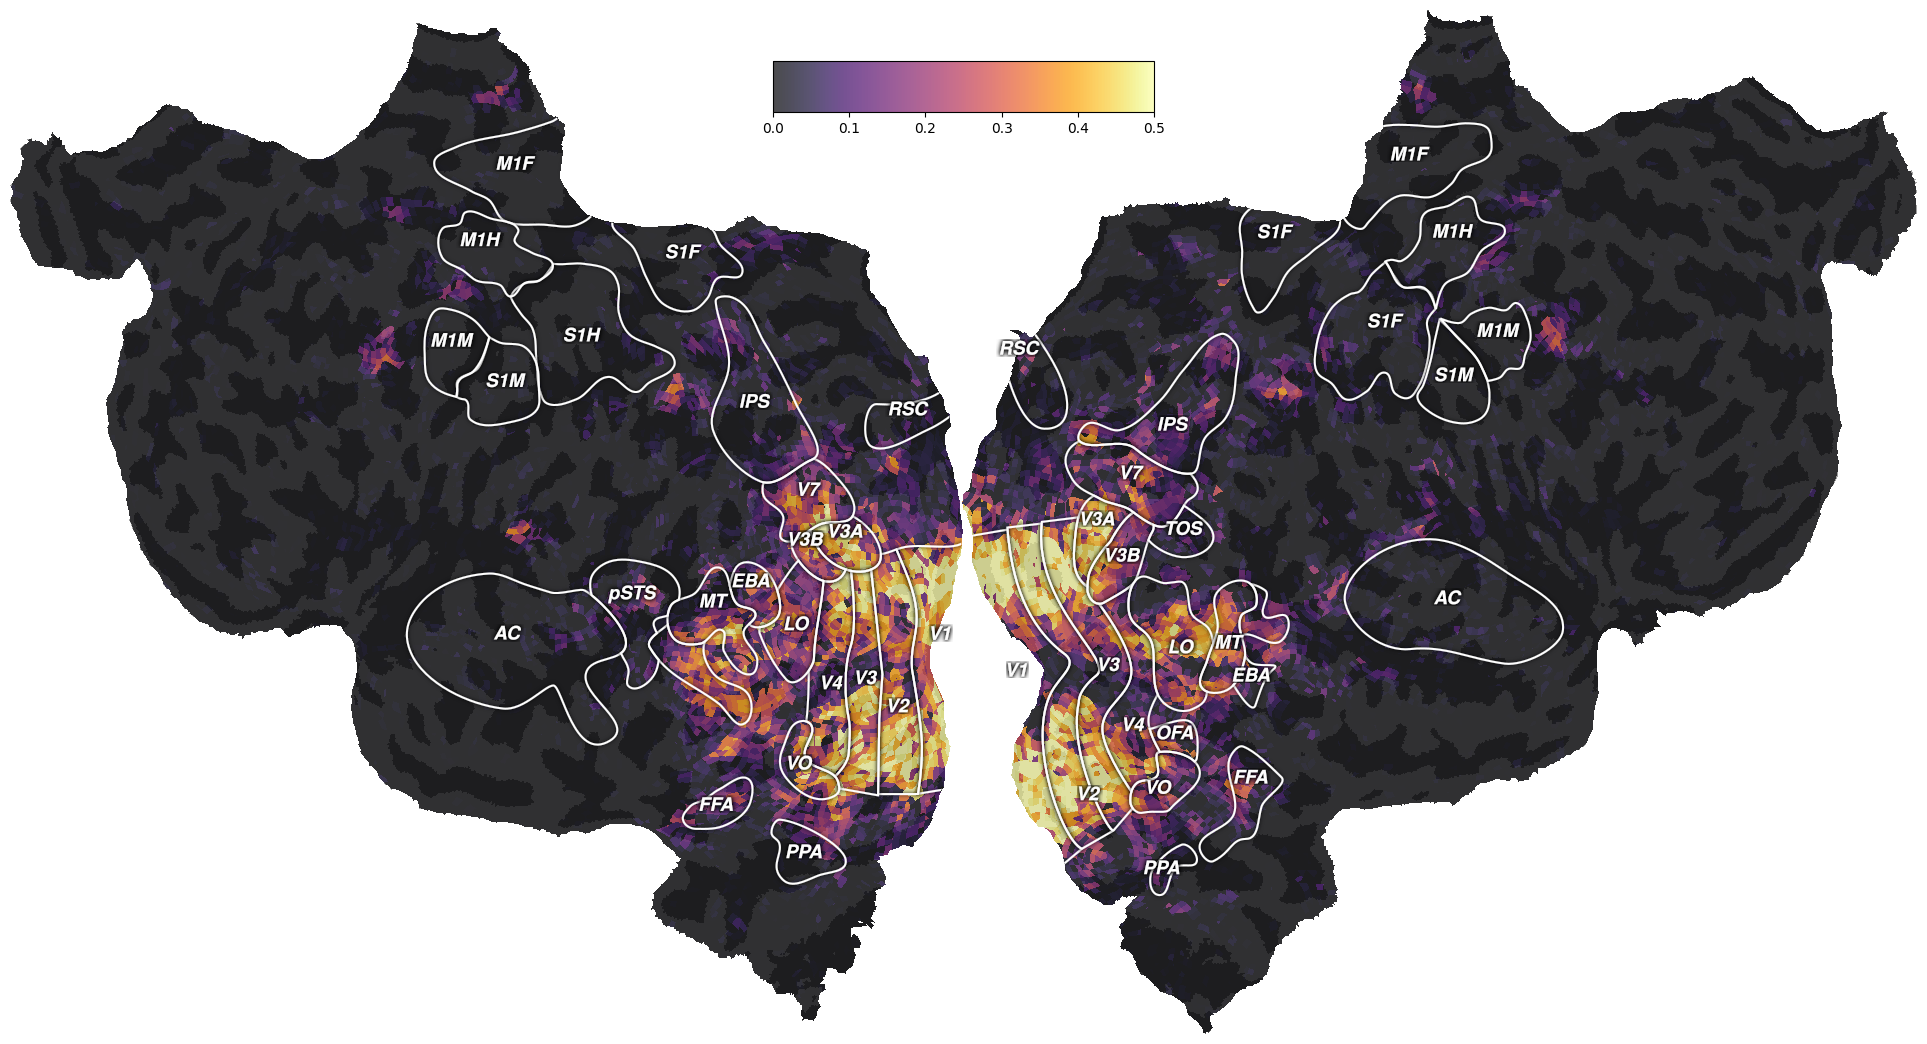

In [12]:
import matplotlib.pyplot as plt
from voxelwise_tutorials.viz import plot_flatmap_from_mapper

mapper_file = os.path.join(directory, "mappers", f"{subject}_mappers.hdf")
ax = plot_flatmap_from_mapper(scores_motion_energy, mapper_file, vmin=0,
                              vmax=0.5)
plt.show()

In [13]:
feature_space = "wordnet"
file_name = os.path.join(directory, "features", f"{feature_space}.hdf")
X_train = load_hdf5_array(file_name, key="X_train")
X_test = load_hdf5_array(file_name, key="X_test")

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

In [14]:
if False:
    from sklearn.base import clone
    pipeline_wordnet = clone(pipeline)
    pipeline_wordnet

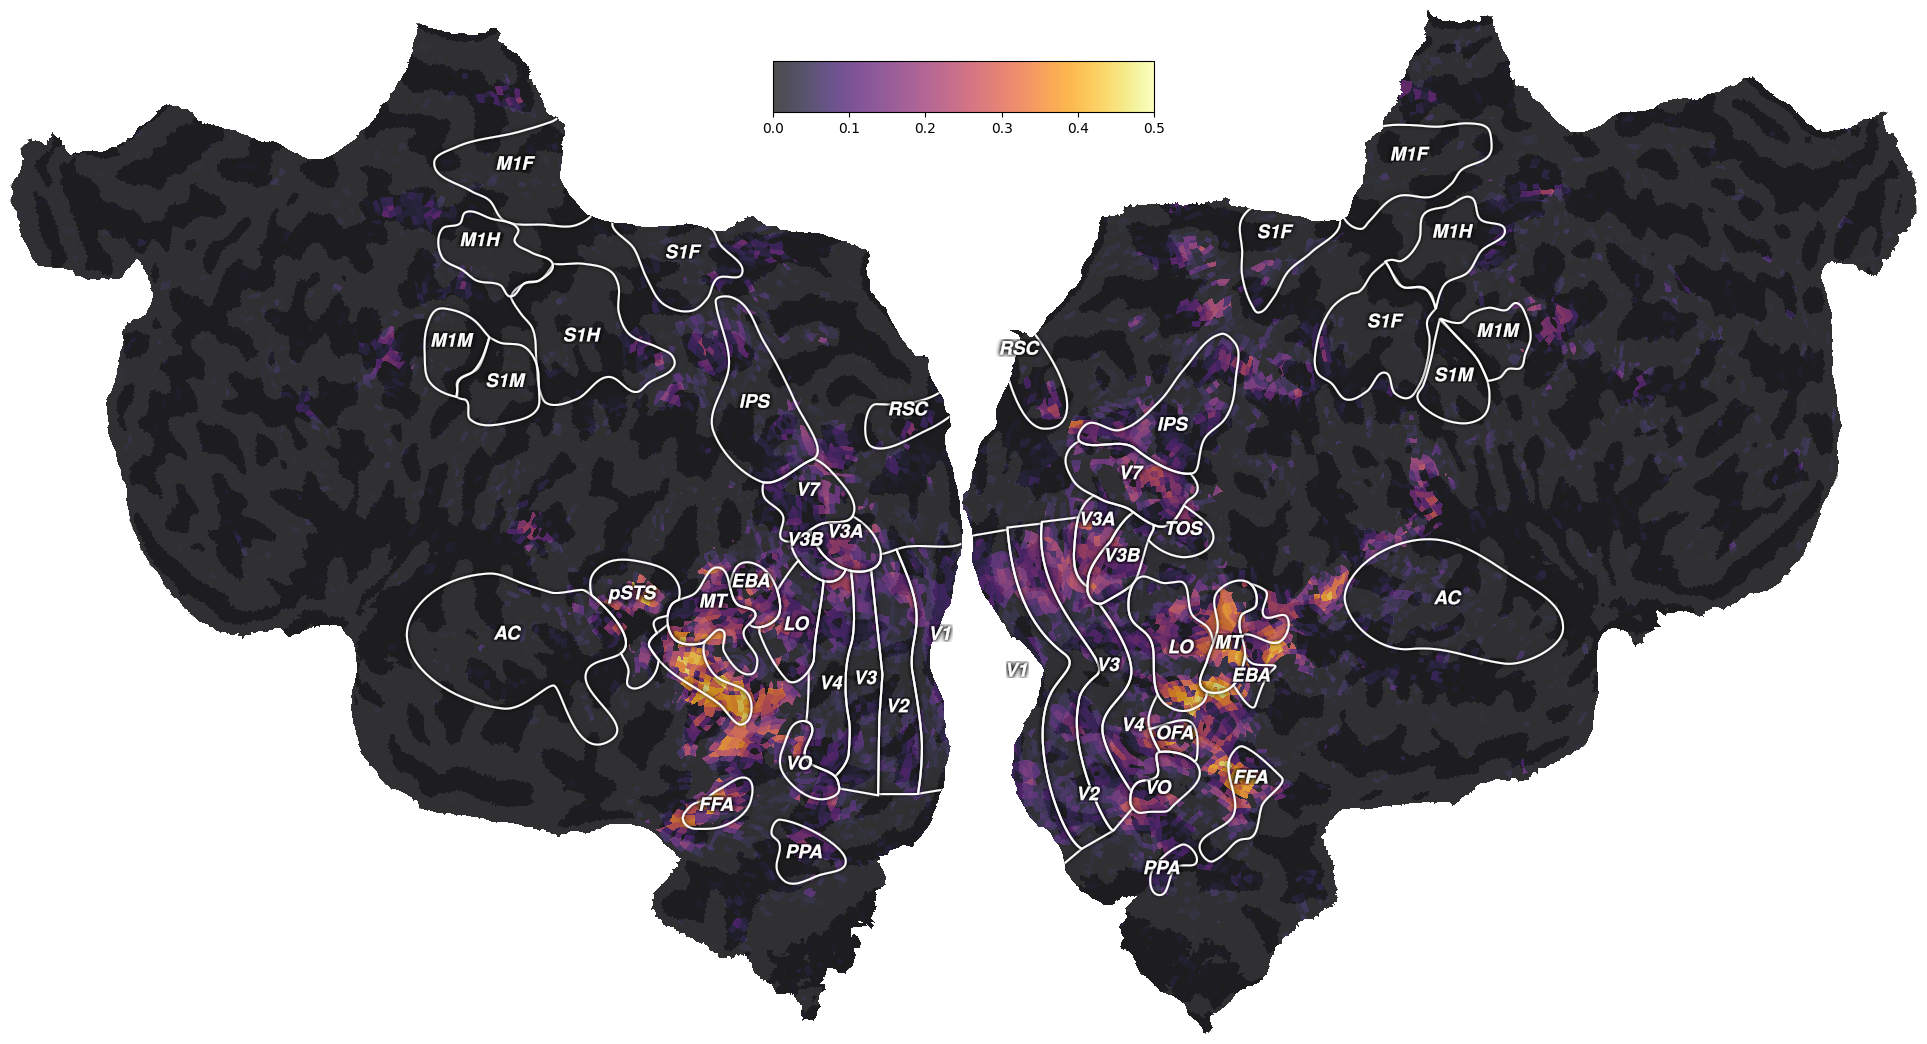

In [15]:
pipeline.fit(X_train, Y_train)
scores_wordnet = pipeline.score(X_test, Y_test)
scores_wordnet = backend.to_numpy(scores_wordnet)

ax = plot_flatmap_from_mapper(scores_wordnet, mapper_file, vmin=0,
                              vmax=0.5)
plt.show()

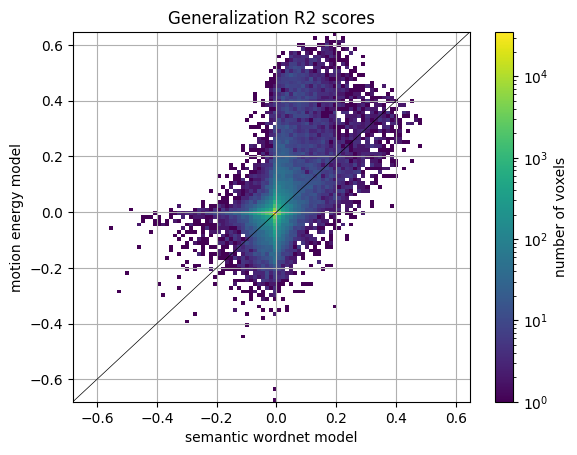

In [16]:
from voxelwise_tutorials.viz import plot_hist2d

ax = plot_hist2d(scores_wordnet, scores_motion_energy)
ax.set(title='Generalization R2 scores', xlabel='semantic wordnet model',
       ylabel='motion energy model')
plt.show()

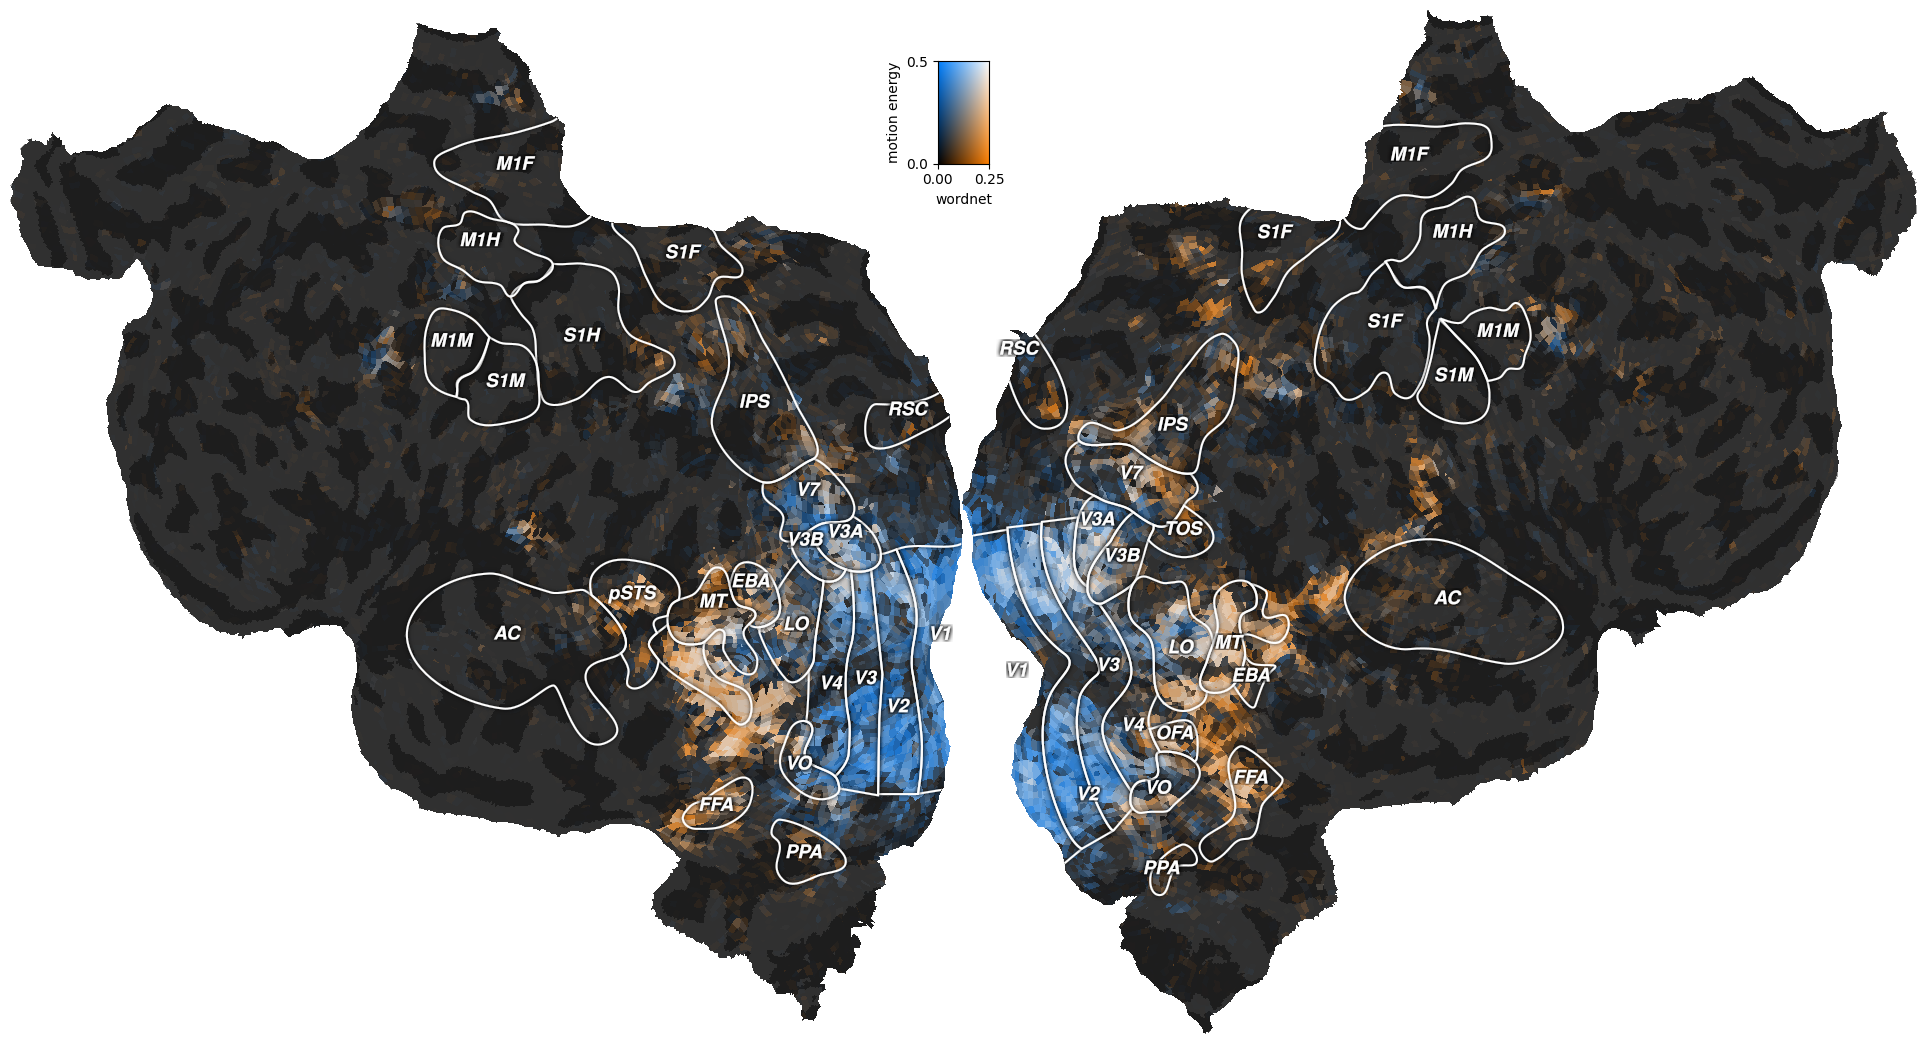

In [17]:
from voxelwise_tutorials.viz import plot_2d_flatmap_from_mapper

mapper_file = os.path.join(directory, "mappers", f"{subject}_mappers.hdf")
ax = plot_2d_flatmap_from_mapper(scores_wordnet, scores_motion_energy,
                                 mapper_file, vmin=0, vmax=0.25, vmin2=0,
                                 vmax2=0.5, label_1="wordnet",
                                 label_2="motion energy")
plt.show()